In [4]:
from datetime import datetime
import numpy as np
import warnings

# from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from pandas.plotting import autocorrelation_plot

import pandas as pd
import matplotlib.pyplot  as plt
import math
import mplfinance as mpf
import yfinance as yf

In [5]:
ticker = "AAPL"

# Download 1-minute interval data for 5 days
df = yf.download(ticker, interval='1d', period='4y')
df.dropna(inplace=True)
df = df.resample('W').mean()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [6]:
df

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2021-05-30,123.450818,124.693667,122.975211,123.854010,71523000.0
2021-06-06,122.026447,122.718821,121.096760,121.864976,69578625.0
2021-06-13,123.938174,124.903096,123.227698,123.996891,65409620.0
2021-06-20,127.713690,128.412426,126.204663,126.954286,91428560.0
2021-06-27,130.449899,131.005757,129.138548,129.982123,70831160.0
...,...,...,...,...,...
2025-04-27,202.764108,204.126320,199.282672,201.066332,47636280.0
2025-05-04,210.228320,211.496655,206.441282,208.358769,57246700.0


In [17]:
result = adfuller(df['Close'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -1.8104064667863156
p-value: 0.37530754832245167


In [7]:
n = int(len(df) * 0.6)
m = int(len(df) * 0.8)

Close=df['Close'].values
df_train, train_close = df.head(n), Close[:n]
df_validation, val_close = df[n:m], Close[n:m]
df_test, test_close = df[:m], Close[m:] 

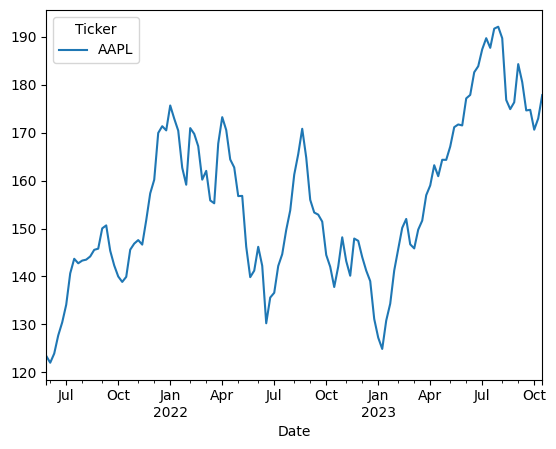

In [8]:
# visual training data
df_train['Close'].plot()
plt.show()

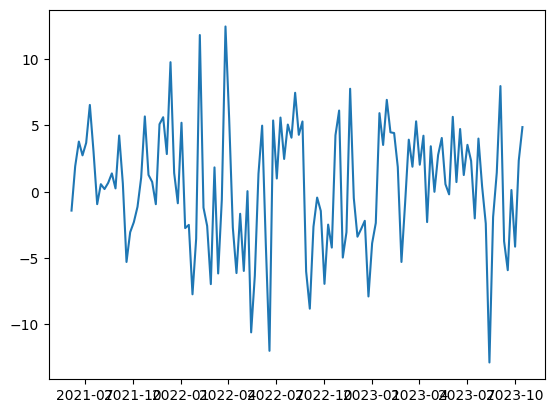

In [9]:
plt.plot(df_train['Close'].diff())

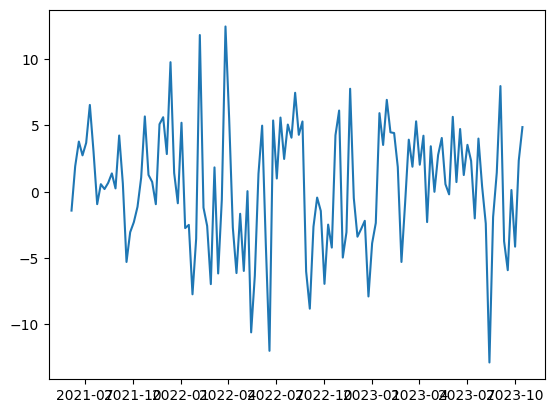

In [10]:
plt.plot(df_train['Close'].diff())

<function matplotlib.pyplot.show(close=None, block=None)>

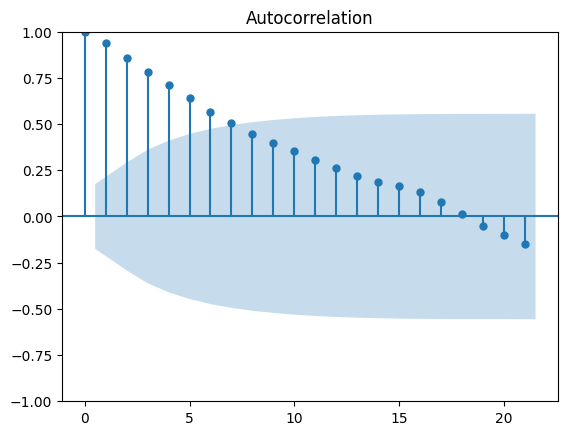

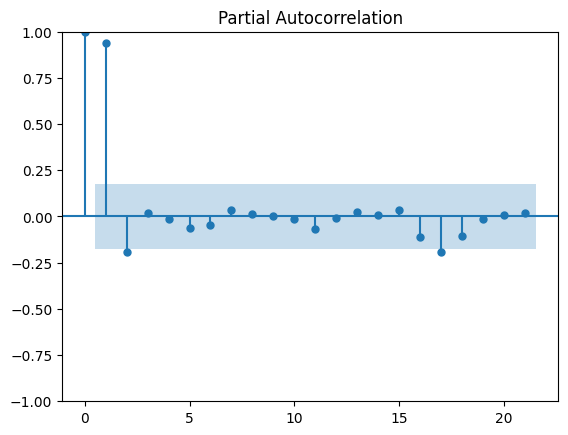

In [11]:
plot_acf(df_train['Close'])
plot_pacf(df_train['Close'])
plt.show

In [13]:
df = yf.download(ticker, interval='1d', period='4y')
df.dropna(inplace=True)
df = df.resample('W').mean()


n = int(len(df) * 0.6)
m = int(len(df) * 0.8)

Close=df['Close'].values
df_train, train_close = df.head(n), Close[:n]
df_validation, val_close = df[n:m], Close[n:m]
df_test, test_close = df[:m], Close[m:] 

[*********************100%***********************]  1 of 1 completed


In [23]:
history=[x for x in train_close]
preds=[]
for i in range(len(test_close)):
    model = ARIMA(history, order=(1, 1, 2))
    model_fit = model.fit()
    output = model_fit.forecast()
    pred = output[0]
    preds.append(pred)
    history.append(test_close[i])

/home/dafahan/code/py/stock-prediction/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/dafahan/code/py/stock-prediction/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [24]:
# evaluate forecasts
rmse = math.sqrt(mean_squared_error(test_close, preds))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 9.691


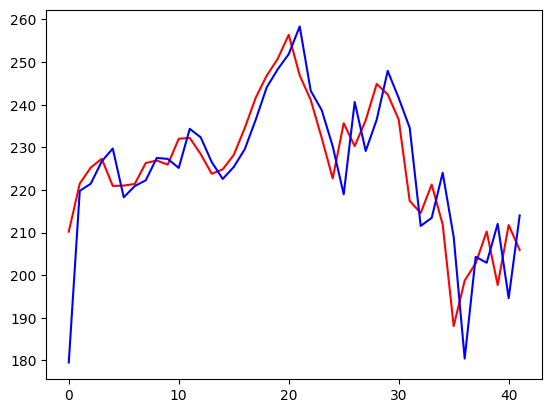

In [25]:
plt.plot(test_close, color='red')
plt.plot(preds, color='blue')

In [26]:
model = ARIMA(df['Close'], order=(1, 1, 2))
model_fit = model.fit()

In [27]:
# Forecast the next 60 days
forecast = model_fit.forecast(steps=60)


In [28]:
last_date = df.index[-1]

# Generate future dates (assuming daily frequency)
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60, freq='D')

In [29]:
forecast_df = pd.DataFrame({'Forecast': forecast}, index=future_dates)

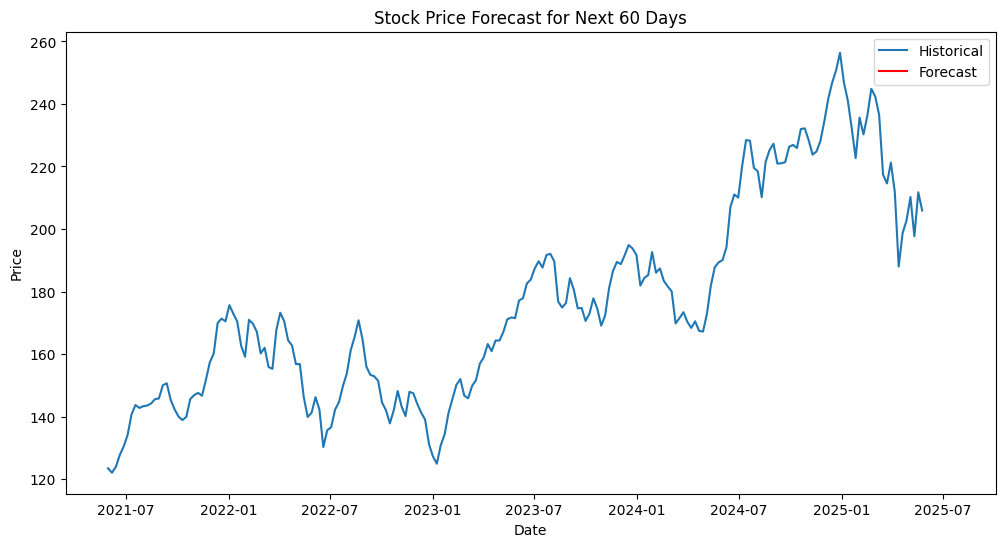

In [30]:
# Plot the historical data
plt.figure(figsize=(12,6))
plt.plot(df['Close'], label='Historical')

# Plot the forecasted data
plt.plot(forecast_df['Forecast'], label='Forecast', color='red')

# Customize the plot
plt.title('Stock Price Forecast for Next 60 Days')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()